In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import numbers
import random

In [3]:
import scipy.stats

### Relevant functions

In [4]:
# Copied from Vectorized EMD.ipynb
from typing import List
import lap

# return distance only, not result
def earth_mover_distance_1(samples1: np.ndarray, samples2: np.ndarray, radixes: List[int], question_types: List[str]):
    ## Sanity check
    if (samples1.shape != samples2.shape):
        print("samples1 and samples2 shape not the same!")
        return

    # N: number of samples in both samples1 and samples2
    numberOfSamples = samples1.shape[0]
    # Q: number of questions in the survey
    numberOfQuestions = samples1.shape[1]

    if (numberOfQuestions != len(radixes)):
        print("radixes length not match!")
        return

    if (numberOfQuestions != len(question_types)):
        print("question_types length not match!")
        return

    ## Calculating distance matrix
    # distance matrix (shape N*N). Element distance[x][y] denotes distance between x-th element in samples1 and y-th element in samples2
    distance = np.zeros((numberOfSamples, numberOfSamples))
    # Memoizes and eliminates unnecessary computations. (z, valueInX) => np.ndarray of cost
    memoMap = {}

    for z in range(0, numberOfQuestions):
        # radio and checkbox question: distance = 1 if different else 0
        if question_types[z] == "radio" or question_types[z] == "checkbox":
            # TODO: probably the following loop can be parallelized?
            for x in range(0, samples1.shape[0]):
                value = samples1[x][z]  # value of samples1 in this col
                
                # Note that we can memoize the operation here: for the same value, the cost contribution of *this question* will always be the same when comparing across entire samples2
                if (z, value) in memoMap.keys():
                    distance[x] += memoMap[(z, value)]
                else:
                    # Note that this operation is vectorized: numpy has builtin function for comparing & setting values
                    memo = np.where(samples2[:, z] == value, 0, 1)
                    memoMap[(z, value)] = memo
                    distance[x] += memo

        # estimate question: distance = absolute difference / radix
        else:
            radix = radixes[z]
            for x in range(0, samples1.shape[0]):
                value = samples1[x][z]
                if (z, value) in memoMap.keys():
                    distance[x] += memoMap[(z, value)]
                else:
                    # Note that this operation is vectorized: numpy has builtin function for subtracting and division across entire row
                    memo = np.abs((samples2[:, z] - value)/radix)
                    memoMap[(z, value)] = memo
                    distance[x] += memo

    ## Find minimum distance matching (i.e. EMD) with Jonker–Volgenant algorithm
    return distance

# return EMD
def earth_mover_distance(samples1: np.ndarray, samples2: np.ndarray, radixes: List[int], question_types: List[str]):
    distance = earth_mover_distance_1(samples1, samples2, radixes, question_types)
    return lap.lapjv(distance)[0]

In [5]:
# n is number of samples to create
# radixes describes what a sample should look like: possibilities for each sample
def createSamples(n, radixes):

    samples = []
    length = len(radixes)

    for x in range(n):
        sample = []
        for y in range(length):
            # for each item, randomly choose using probabilities
            radix = radixes[y]
            newNumber = random.randint(0, radix-1)
            sample.append(newNumber)
        samples.append(sample)

    return np.array(samples)

### Data Preprocessing

In [6]:
df_300 = pd.read_csv("../../PEW_Jun29_300.csv")

In [7]:
# Subtract min from all responses to estimate question. Simplifies random sample generation
c_age = df_300['What is your age?']
c_age -= c_age.min()

In [8]:
sample_300 = np.array(df_300.drop('Worker ID', axis=1).applymap(
    # convert answers to integers (within radix)
    lambda x: {
        # dictionary for radio question
        'Easier': 0,
        'Same': 1,
        'Harder': 2,
        # dictionary for boolean radio
        'Yes': 1,
        'No': 0,
    }.get(x, int(x) if isinstance(x, numbers.Number) else x) # if an estimate, make it an int number
))
sample_300

array([[ 2,  2,  2, ...,  0,  1, 20],
       [ 0,  0,  0, ...,  0,  1,  0],
       [ 2,  1,  0, ...,  2,  1, 21],
       ...,
       [ 0,  0,  0, ...,  0,  1, 33],
       [ 2,  2,  2, ...,  2,  1, 29],
       [ 0,  2,  0, ...,  0,  1, 35]])

In [9]:
question_types = ["radio", "radio", "radio", "radio", "radio", "radio", "radio", "radio", "estimate"]

c_age = df_300['What is your age?']
radix = [3, 3, 3, 3, 3, 3, 3, 2, int(c_age.max()-c_age.min())]

# Variance & Mean against Number of iterations

This is to verify whether the variances are close enough for test-random and random-random samples. If so, we should be able to perform homoscedastic T Test on them

Also, how many iterations do we really need to generate reliable results?
From the result, it seems that a small number of iteration would suffice.

### Random Sample Generation

In [9]:
ns = [2,5] + list(range(10,100,10)) + list(range(100,1000,100)) + [1000]
# + list(range(1000,10001,1000))

In [10]:
# Raw data
distances_n_random = []
distances_n_test = []

# Variance (what we actually care about)
variance_n_random = []
variance_n_test = []

mean_n_random = []
mean_n_test = []

# Iterate and calculate
for n in ns:
    distances_random = []
    distances_test = []
    
    for i in range(0, n):
        sample_random = createSamples(300,radix)
        sample_random2 = createSamples(300,radix)
        
        distance_random = earth_mover_distance(sample_random, sample_random2, radix, question_types)
        distance_test = earth_mover_distance(sample_random, sample_300, radix, question_types)

        distances_random.append(distance_random)
        distances_test.append(distance_test)
        
    # Store raw data
    distances_n_random.append(distances_random)
    distances_n_test.append(distances_test)
    
    # Store variance
    variance_n_random.append(np.var(np.array(distances_random)))
    variance_n_test.append(np.var(np.array(distances_test)))
    
    mean_n_random.append(np.mean(np.array(distances_random)))
    mean_n_test.append(np.mean(np.array(distances_test)))

#### Save Data for Replication

In [34]:
np.version.version

'1.22.3'

In [35]:
# n (number of iterations) values
a_ns = np.array(ns)

# n * variance of each iteration
a_variance_n_random = np.array(variance_n_random)
a_variance_n_test = np.array(variance_n_test)

# n * mean of each iteration
a_mean_n_random = np.array(mean_n_random)
a_mean_n_test = np.array(mean_n_test)

In [36]:
# n * EMD of each iteration
a_distances_n_random = np.array(distances_n_random, dtype=object)
# n * EMD of each iteration
a_distances_n_test = np.array(distances_n_test, dtype=object)

In [37]:
np.savez('iterationTest-Jul26.npz', 
         a_ns=a_ns,
         a_variance_n_random=a_variance_n_random, 
         a_variance_n_test=a_variance_n_test,
         a_mean_n_random=a_mean_n_random,
         a_mean_n_test=a_mean_n_test
        )

In [38]:
np.savez('iterationTest-rawData-Jul26.npz', 
         a_ns=a_ns,
         a_distances_n_random=a_distances_n_random, 
         a_distances_n_test=a_distances_n_test
        )

### Figures

(array([  6.,  46.,  95., 166., 246., 205., 142.,  59.,  28.,   7.]),
 array([482.63076923, 487.71846154, 492.80615385, 497.89384615,
        502.98153846, 508.06923077, 513.15692308, 518.24461538,
        523.33230769, 528.42      , 533.50769231]),
 <BarContainer object of 10 artists>)

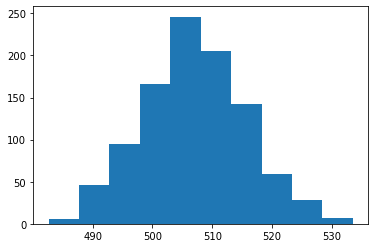

In [11]:
plt.hist(np.array(distances_n_random[-1]))

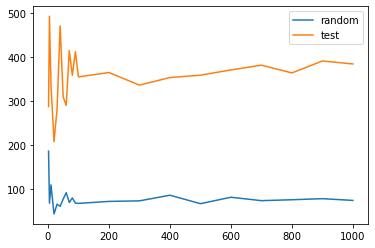

In [12]:
plt.plot(ns, variance_n_random, label = "random")
plt.plot(ns, variance_n_test, label = "test")

plt.legend()
plt.show()

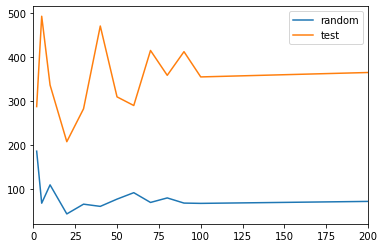

In [14]:
plt.plot(ns, variance_n_random, label = "random")
plt.plot(ns, variance_n_test, label = "test")

plt.xlim([0, 200])
plt.legend()
plt.show()

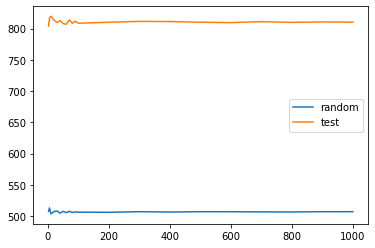

In [15]:
plt.plot(ns, mean_n_random, label = "random")
plt.plot(ns, mean_n_test, label = "test")

plt.legend()
plt.show()

# Histogram of Distance Matrix

In [16]:
sample_random = createSamples(300,radix)
sample_random2 = createSamples(300,radix)

distance_matrix_random = earth_mover_distance_1(sample_random, sample_random2, radix, question_types)
distance_matrix_test = earth_mover_distance_1(sample_random, sample_300, radix, question_types)

(array([ 6., 23., 20., 75.,  8., 87., 33., 27., 20.,  1.]),
 array([2.04615385, 2.65076923, 3.25538462, 3.86      , 4.46461538,
        5.06923077, 5.67384615, 6.27846154, 6.88307692, 7.48769231,
        8.09230769]),
 <BarContainer object of 10 artists>)

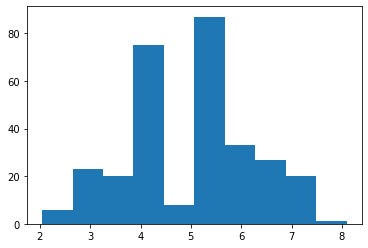

In [17]:
plt.hist(distance_matrix_test[0])

(array([ 8., 14., 10., 51., 54., 31., 75., 36., 15.,  6.]),
 array([2.01538462, 2.68461538, 3.35384615, 4.02307692, 4.69230769,
        5.36153846, 6.03076923, 6.7       , 7.36923077, 8.03846154,
        8.70769231]),
 <BarContainer object of 10 artists>)

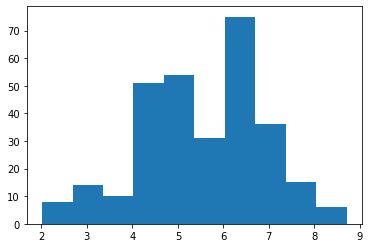

In [39]:
plt.hist(distance_matrix_random[0])

(array([[ 0.,  1.,  8., ..., 46., 28.,  4.],
        [ 1.,  1.,  1., ..., 62., 30.,  4.],
        [ 1.,  0.,  4., ..., 49., 28.,  6.],
        ...,
        [ 1.,  1.,  1., ..., 52., 21.,  5.],
        [ 0.,  2.,  4., ..., 60., 21.,  4.],
        [ 0.,  0.,  8., ..., 36., 35.,  9.]]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 300 BarContainer objects>)

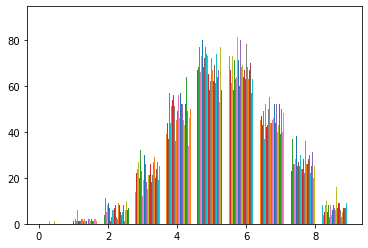

In [18]:
plt.hist(distance_matrix_test)

(array([[ 0.,  1.,  7., ..., 57., 34.,  7.],
        [ 0.,  1.,  6., ..., 62., 17.,  9.],
        [ 0.,  0.,  6., ..., 46., 23.,  7.],
        ...,
        [ 0.,  0.,  5., ..., 66., 38., 10.],
        [ 0.,  0.,  7., ..., 43., 34.,  9.],
        [ 0.,  1., 11., ..., 58., 12.,  7.]]),
 array([0.        , 0.89846154, 1.79692308, 2.69538462, 3.59384615,
        4.49230769, 5.39076923, 6.28923077, 7.18769231, 8.08615385,
        8.98461538]),
 <a list of 300 BarContainer objects>)

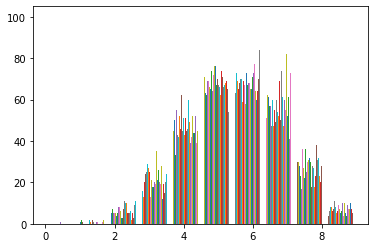

In [40]:
plt.hist(distance_matrix_random)

# P value against sample size

It appears that even with a tiny sample size (n>=5), the p-score will be extremely significant for us to determine that the responses are not random (or more precisely, not ENTIRELY random).

In [51]:
ITERATION_NUMBER = 100

sample_sizes = list(range(2,15))
p_values = []

for n in sample_sizes:
    distances_random = []
    distances_test = []

    for i in range(0, ITERATION_NUMBER):
        sample_random = createSamples(n,radix)
        sample_random2 = createSamples(n,radix)

        distance_random = earth_mover_distance(sample_random, sample_random2, radix, question_types)
        distance_test = earth_mover_distance(sample_random, sample_300[:n], radix, question_types)

        distances_random.append(distance_random)
        distances_test.append(distance_test)

    res = scipy.stats.ttest_ind(distances_random, distances_test, equal_var=False)
    print(f"n = {n}: p-value (two-sided test): {res[1]}")
    
    p_values.append(res[1])

n = 2: p-value (two-sided test): 0.39053518054359604
n = 3: p-value (two-sided test): 0.24550492551352382
n = 4: p-value (two-sided test): 0.0005496347219146371
n = 5: p-value (two-sided test): 4.417182872518552e-07
n = 6: p-value (two-sided test): 2.9465868061501615e-08
n = 7: p-value (two-sided test): 0.0003855347622310324
n = 8: p-value (two-sided test): 3.5723636717294e-08
n = 9: p-value (two-sided test): 1.772356249586847e-06
n = 10: p-value (two-sided test): 3.147344945174147e-07
n = 11: p-value (two-sided test): 3.3272303218850506e-08
n = 12: p-value (two-sided test): 1.4214926919513021e-09
n = 13: p-value (two-sided test): 1.132466832042509e-09
n = 14: p-value (two-sided test): 2.321439345700646e-17


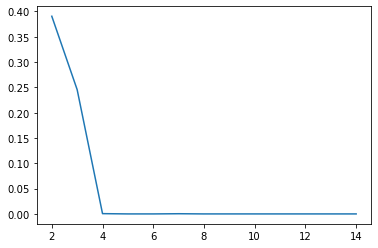

In [52]:
plt.plot(sample_sizes, p_values)

A template code for one-sided t test with scipy

```python
res = scipy.stats.ttest_ind(..., ..., equal_var=False, alternative="less")
print(res[1])
```

# P value against % of random data

As demonstrated in the test above:

Even with a very tiny sample size (n), the p value of t-test will still be very small for us to reject null hypothesis (equal mean). 

This is more significant (p value gets halfed) when we use the one-sided test, i.e. with alternative hypothesis of distance_random < distance_test.

## Mixing Random data

Here we want to explore, if we mix random data into test dataset, will it significantly alter the p-value.
In addition, with a given confidence, how large is it possible to change the resulting mean?

random_size = 0: t-stat: -146.61936421542572 	p-value (two-sided test): 4.647471260620236e-159
random_size = 20: t-stat: -133.1833847366681 	p-value (two-sided test): 2.621834282928002e-155
random_size = 40: t-stat: -119.55266626270759 	p-value (two-sided test): 2.3218975184853824e-142
random_size = 60: t-stat: -110.92595202825751 	p-value (two-sided test): 2.1479407253472902e-138
random_size = 80: t-stat: -98.68601923313673 	p-value (two-sided test): 1.7145399883315256e-141
random_size = 100: t-stat: -85.79854861322085 	p-value (two-sided test): 5.040855577886768e-131
random_size = 120: t-stat: -75.3293502816714 	p-value (two-sided test): 3.211785400147347e-122
random_size = 140: t-stat: -59.7332979124898 	p-value (two-sided test): 8.868133986647079e-116
random_size = 160: t-stat: -49.83532708122192 	p-value (two-sided test): 8.778177449062361e-105
random_size = 180: t-stat: -39.823196076399284 	p-value (two-sided test): 2.5519096193923942e-92
random_size = 200: t-stat: -32.2591963733

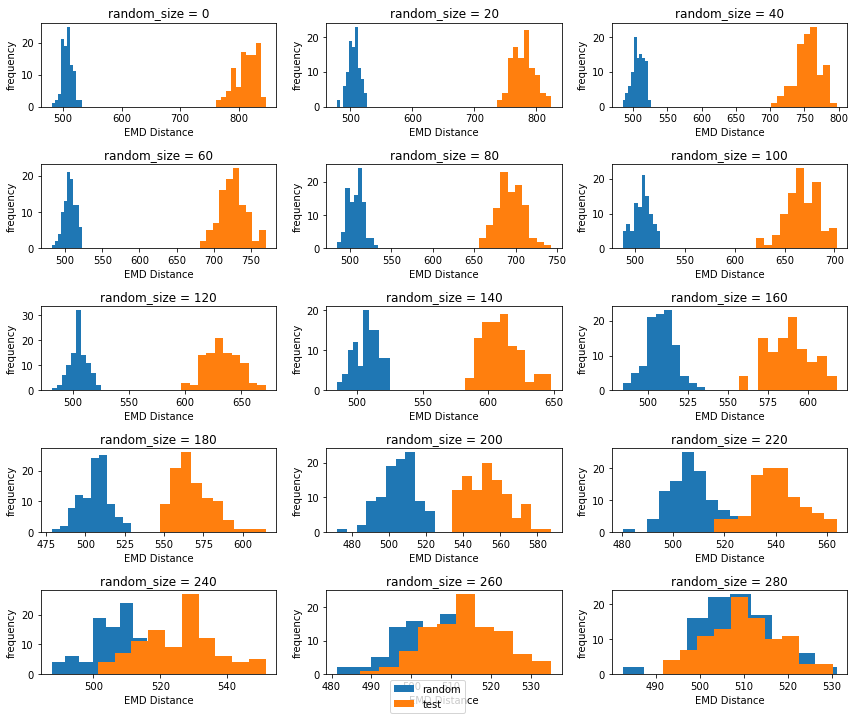

In [176]:
ITERATION_NUMBER = 100
SAMPLE_SIZE = 300

random_sizes = list(range(0,SAMPLE_SIZE,20))
p_values = np.zeros((len(random_sizes)))
means_array = np.zeros((len(random_sizes), ITERATION_NUMBER, 9))  # 9 is number of question

mean_distance_random = np.zeros((len(random_sizes)))
mean_distance_test = np.zeros((len(random_sizes)))

var_distance_random = np.zeros((len(random_sizes)))
var_distance_test = np.zeros((len(random_sizes)))

fig, axs = plt.subplots(5,3, figsize=(12,10))

for index, random_size in enumerate(random_sizes):
    distances_random = []
    distances_test = []

    for i in range(0, ITERATION_NUMBER):
        sample_random = createSamples(SAMPLE_SIZE,radix)
        sample_random2 = createSamples(SAMPLE_SIZE,radix)
        
        if random_size == 0:
            sample_test = sample_300
        else:
            # mixing up with random data
            sample_random3 = createSamples(random_size,radix)
            sample_test = np.concatenate((sample_random3, sample_300[:(SAMPLE_SIZE-random_size)]))
                    
        # store the mean response for each questions
        means_array[index][i] = sample_test.mean(axis=0)

        distance_random = earth_mover_distance(sample_random, sample_random2, radix, question_types)
        distance_test = earth_mover_distance(sample_random, sample_test, radix, question_types)

        distances_random.append(distance_random)
        distances_test.append(distance_test)

    res = scipy.stats.ttest_ind(distances_random, distances_test, equal_var=False)
    print(f"random_size = {random_size}: t-stat: {res[0]} \tp-value (two-sided test): {res[1]}")
    
    # store the values
    p_values[index] = res[1]
    mean_distance_random[index] = np.mean(distances_random)
    mean_distance_test[index] = np.mean(distances_test)
    var_distance_random[index] = np.var(distances_random)
    var_distance_test[index] = np.var(distances_test)
    
    # plotting
    axs[index//3][index%3].hist(distances_random, label="random")
    axs[index//3][index%3].hist(distances_test,label="test")

    axs[index//3][index%3].set_title(f"random_size = {random_size}")    
    axs[index//3][index%3].set_xlabel("EMD Distance")
    axs[index//3][index%3].set_ylabel("frequency")
    # axs[index//3][index%3].legend()
    
handles, labels = axs[0][0].get_legend_handles_labels()

fig.legend(handles, labels, loc='lower center')
plt.tight_layout()  # to avoid overlapping titles
plt.show()

## Figures

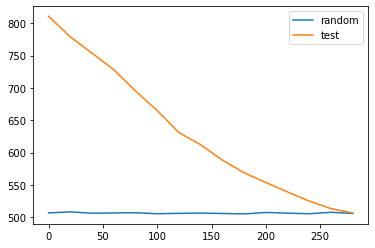

In [116]:
# Mean EMD vs random_size
plt.plot(random_sizes, mean_distance_random, label="random")
plt.plot(random_sizes, mean_distance_test, label="test")

plt.legend()
plt.show()

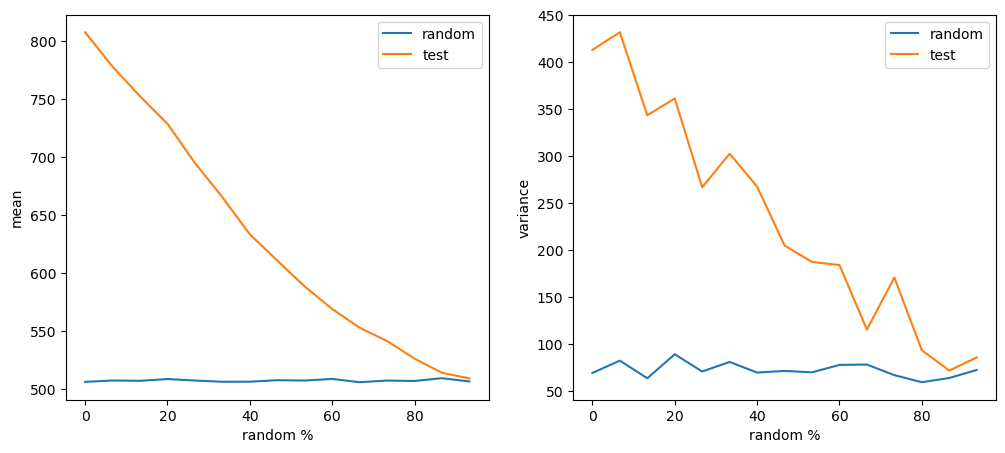

In [93]:
plt.style.use('default')

fig, axs = plt.subplots(1,2, figsize=(12,5))

# Mean EMD vs random_size
axs[0].plot(np.array(random_sizes)/3, mean_distance_random, label="random")
axs[0].plot(np.array(random_sizes)/3, mean_distance_test, label="test")
axs[0].set_xlabel("random %")
axs[0].set_ylabel("mean")
axs[0].legend()

axs[1].plot(np.array(random_sizes)/3, var_distance_random, label="random")
axs[1].plot(np.array(random_sizes)/3, var_distance_test, label="test")
axs[1].set_xlabel("random %")
axs[1].set_ylabel("variance")
axs[1].legend()

plt.show()
fig.savefig("mean_var_300.png", transparent=True)

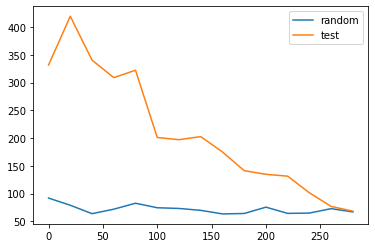

In [117]:
# Variance EMD vs random_size
plt.plot(random_sizes, var_distance_random, label="random")
plt.plot(random_sizes, var_distance_test, label="test")

plt.legend()
plt.show()

# Signal to Noise Ratio?

## Single Tests

In [165]:
ITERATION_NUMBER = 400
SAMPLE_SIZE = 300

distances_random = []
distances_test = []

random_size = 0

for i in range(0, ITERATION_NUMBER):
    sample_random = createSamples(SAMPLE_SIZE,radix)
    sample_random2 = createSamples(SAMPLE_SIZE,radix)

    if random_size == 0:
        sample_test = sample_300
    else:
        # mixing up with random data
        sample_random3 = createSamples(random_size,radix)
        sample_test = np.concatenate((sample_random3, sample_300[:(SAMPLE_SIZE-random_size)]))

    distance_random = earth_mover_distance(sample_random, sample_random2, radix, question_types)
    distance_test = earth_mover_distance(sample_random, sample_test, radix, question_types)

    distances_random.append(distance_random)
    distances_test.append(distance_test)

In [120]:
res = scipy.stats.anderson_ksamp((distances_random, distances_test))
res

<ipython-input-120-d0ece17efd02>:1: UserWarning: p-value floored: true value smaller than 0.001
  res = scipy.stats.anderson_ksamp((distances_random, distances_test))


Anderson_ksampResult(statistic=405.73075534749455, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.001)

(array([ 9., 15., 36., 55., 86., 88., 64., 29., 12.,  6.]),
 array([755.66153846, 766.73846154, 777.81538462, 788.89230769,
        799.96923077, 811.04615385, 822.12307692, 833.2       ,
        844.27692308, 855.35384615, 866.43076923]),
 <BarContainer object of 10 artists>)

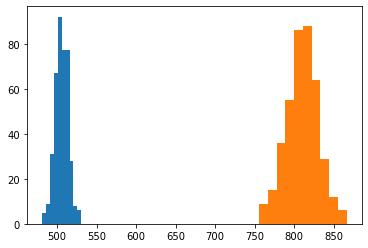

In [166]:
plt.hist(distances_random)
plt.hist(distances_test)

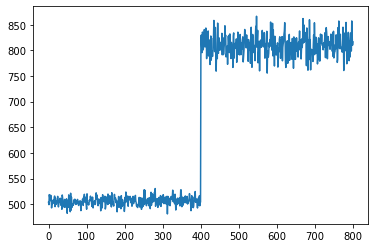

In [167]:
arr_dis_combined = np.array(distances_random + distances_test)
plt.plot(list(range(0,800)), arr_dis_combined)

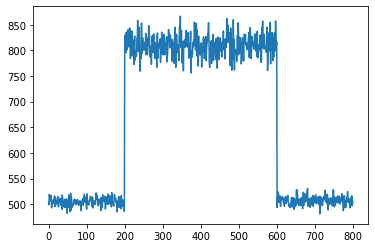

In [168]:
arr_dis_combined = np.array(distances_random[0:200] + distances_test + distances_random[200:])
plt.plot(list(range(0,800)), arr_dis_combined)

In [169]:
len(distances_test)

400

In [170]:
np.std(arr_dis_combined)

152.91912623311512

In [171]:
np.mean(distances_test)

810.2920000000001

In [172]:
(np.mean(distances_test)-np.mean(distances_random)) / np.std(arr_dis_combined)

1.989831084343048

In [175]:
(np.mean(distances_test)-np.mean(distances_random)) / np.std(distances_random)

36.718208506132186

In [173]:
np.mean(distances_test) / np.std(arr_dis_combined)

5.298827033348094

In [174]:
np.mean(distances_random) / np.std(arr_dis_combined)

3.3089959490050465

### Repeated w/ higher noises

In [154]:
ITERATION_NUMBER = 400
SAMPLE_SIZE = 300

distances_random = []
distances_test = []

random_size = 200

for i in range(0, ITERATION_NUMBER):
    sample_random = createSamples(SAMPLE_SIZE,radix)
    sample_random2 = createSamples(SAMPLE_SIZE,radix)

    if random_size == 0:
        sample_test = sample_300
    else:
        # mixing up with random data
        sample_random3 = createSamples(random_size,radix)
        sample_test = np.concatenate((sample_random3, sample_300[:(SAMPLE_SIZE-random_size)]))

    distance_random = earth_mover_distance(sample_random, sample_random2, radix, question_types)
    distance_test = earth_mover_distance(sample_random, sample_test, radix, question_types)

    distances_random.append(distance_random)
    distances_test.append(distance_test)

(array([ 2., 19., 43., 50., 87., 87., 67., 31., 13.,  1.]),
 array([524.04615385, 530.10307692, 536.16      , 542.21692308,
        548.27384615, 554.33076923, 560.38769231, 566.44461538,
        572.50153846, 578.55846154, 584.61538462]),
 <BarContainer object of 10 artists>)

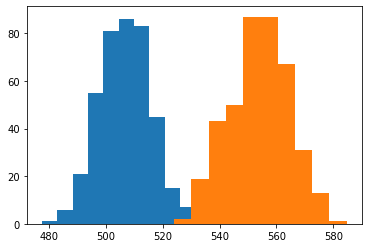

In [155]:
plt.hist(distances_random)
plt.hist(distances_test)

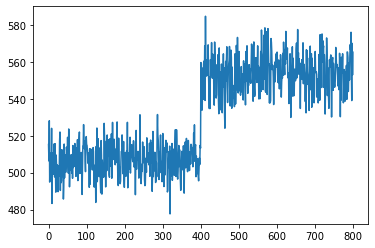

In [156]:
arr_dis_combined = np.array(distances_random + distances_test)
plt.plot(list(range(0,800)), arr_dis_combined)

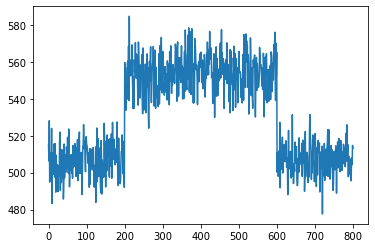

In [157]:
arr_dis_combined = np.array(distances_random[0:200] + distances_test + distances_random[200:])
plt.plot(list(range(0,800)), arr_dis_combined)

In [158]:
len(distances_test)

400

In [159]:
np.std(arr_dis_combined)

25.46846791309278

In [163]:
np.std(distances_random)

8.891042483521659

In [160]:
np.mean(distances_test)

553.8076153846154

In [164]:
(np.mean(distances_test)-np.mean(distances_random)) / np.std(arr_dis_combined)

1.8479200424733002

In [162]:
np.mean(distances_random) / np.std(arr_dis_combined)

19.896914286564414

## Looped Test

random_size = 0: SNR: 36.207853888258214
random_size = 20: SNR: 29.802518871377238
random_size = 40: SNR: 30.75215189251044
random_size = 60: SNR: 23.297714868442924
random_size = 80: SNR: 22.29094915967424
random_size = 100: SNR: 17.674679933883294
random_size = 120: SNR: 15.209777205379252
random_size = 140: SNR: 12.209014911759159
random_size = 160: SNR: 9.693595185334651
random_size = 180: SNR: 6.829623233299809
random_size = 200: SNR: 5.315312407642496
random_size = 220: SNR: 4.165046572850368
random_size = 240: SNR: 2.5008296617681935
random_size = 260: SNR: 0.5834964613901412
random_size = 280: SNR: 0.30596994476205935


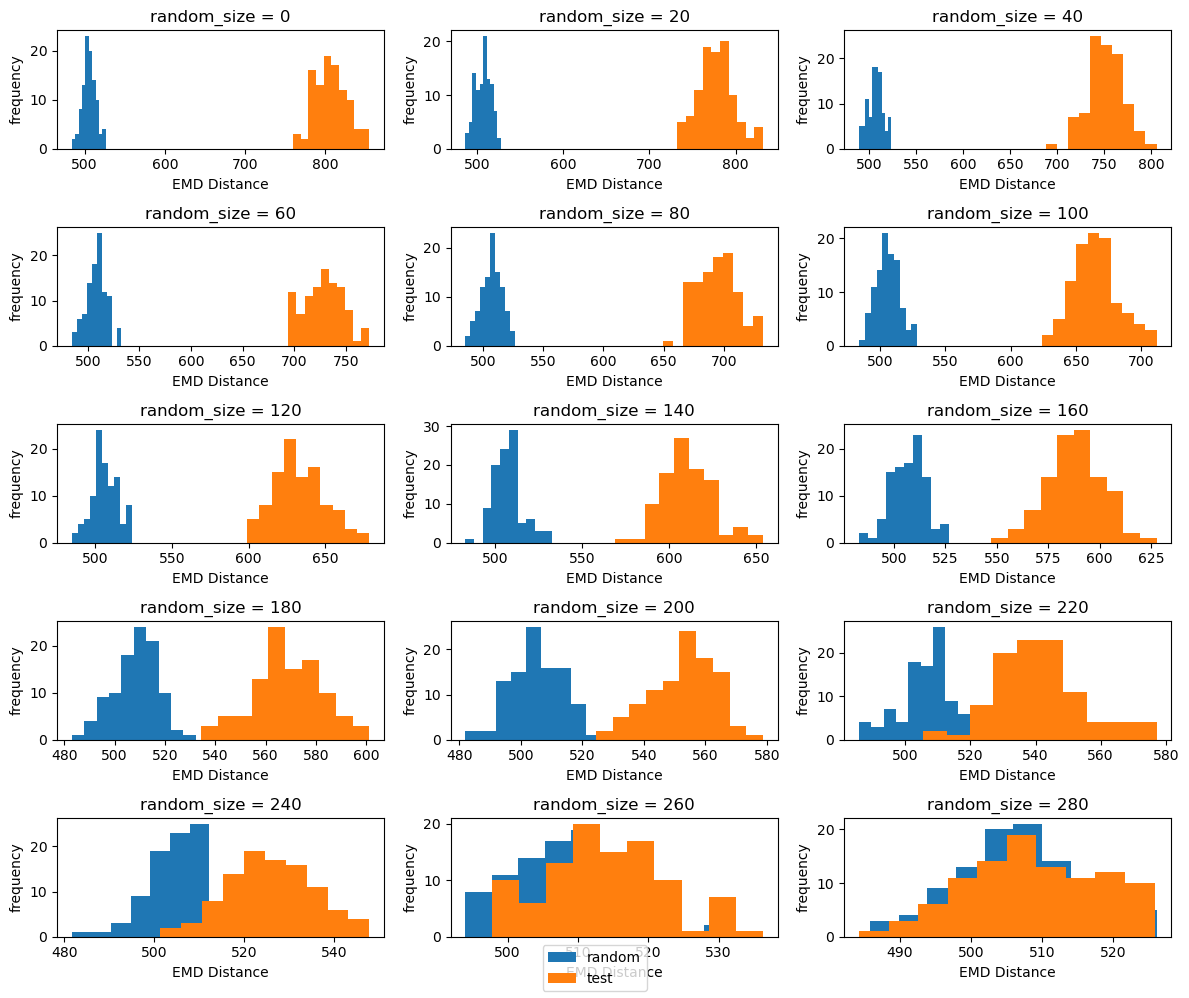

In [72]:
ITERATION_NUMBER = 100
SAMPLE_SIZE = 300

random_sizes = list(range(0,SAMPLE_SIZE,20))
snr_values = np.zeros((len(random_sizes)))
means_array = np.zeros((len(random_sizes), ITERATION_NUMBER, 9))  # 9 is number of question

mean_distance_random = np.zeros((len(random_sizes)))
mean_distance_test = np.zeros((len(random_sizes)))

var_distance_random = np.zeros((len(random_sizes)))
var_distance_test = np.zeros((len(random_sizes)))

fig, axs = plt.subplots(5,3, figsize=(12,10))

for index, random_size in enumerate(random_sizes):
    distances_random = []
    distances_test = []

    for i in range(0, ITERATION_NUMBER):
        sample_random = createSamples(SAMPLE_SIZE,radix)
        sample_random2 = createSamples(SAMPLE_SIZE,radix)
        
        if random_size == 0:
            sample_test = sample_300[:SAMPLE_SIZE]
        else:
            # mixing up with random data
            sample_random3 = createSamples(random_size,radix)
            sample_test = np.concatenate((sample_random3, sample_300[:(SAMPLE_SIZE-random_size)]))
                    
        # store the mean response for each questions
        means_array[index][i] = sample_test.mean(axis=0)

        distance_random = earth_mover_distance(sample_random, sample_random2, radix, question_types)
        distance_test = earth_mover_distance(sample_random, sample_test, radix, question_types)

        distances_random.append(distance_random)
        distances_test.append(distance_test)

    snr = (np.mean(distances_test)-np.mean(distances_random)) / np.std(distances_random)
    print(f"random_size = {random_size}: SNR: {snr}")
    
    # store the values
    snr_values[index] = snr
    mean_distance_random[index] = np.mean(distances_random)
    mean_distance_test[index] = np.mean(distances_test)
    var_distance_random[index] = np.var(distances_random)
    var_distance_test[index] = np.var(distances_test)
    
    # plotting
    axs[index//3][index%3].hist(distances_random, label="random")
    axs[index//3][index%3].hist(distances_test,label="test")

    axs[index//3][index%3].set_title(f"random_size = {random_size}")    
    axs[index//3][index%3].set_xlabel("EMD Distance")
    axs[index//3][index%3].set_ylabel("frequency")
    # axs[index//3][index%3].legend()
    
handles, labels = axs[0][0].get_legend_handles_labels()

fig.legend(handles, labels, loc='lower center')
plt.tight_layout()  # to avoid overlapping titles
plt.show()

fig.savefig("emd_dists_300.png", transparent=True)

random_size = 0: SNR: 38.06320323230696
random_size = 20: SNR: 29.775011169833984
random_size = 40: SNR: 25.64686846169147
random_size = 60: SNR: 24.53962618394633
random_size = 80: SNR: 24.533812184693925
random_size = 100: SNR: 20.066769390958985
random_size = 120: SNR: 13.065918432515808
random_size = 140: SNR: 11.320396341992844
random_size = 160: SNR: 8.920075142880316
random_size = 180: SNR: 7.49177918220718
random_size = 200: SNR: 5.767371658451379
random_size = 220: SNR: 3.7358662242787184
random_size = 240: SNR: 2.418937833268531
random_size = 260: SNR: 0.6852292516444188
random_size = 280: SNR: 0.42271016048130045


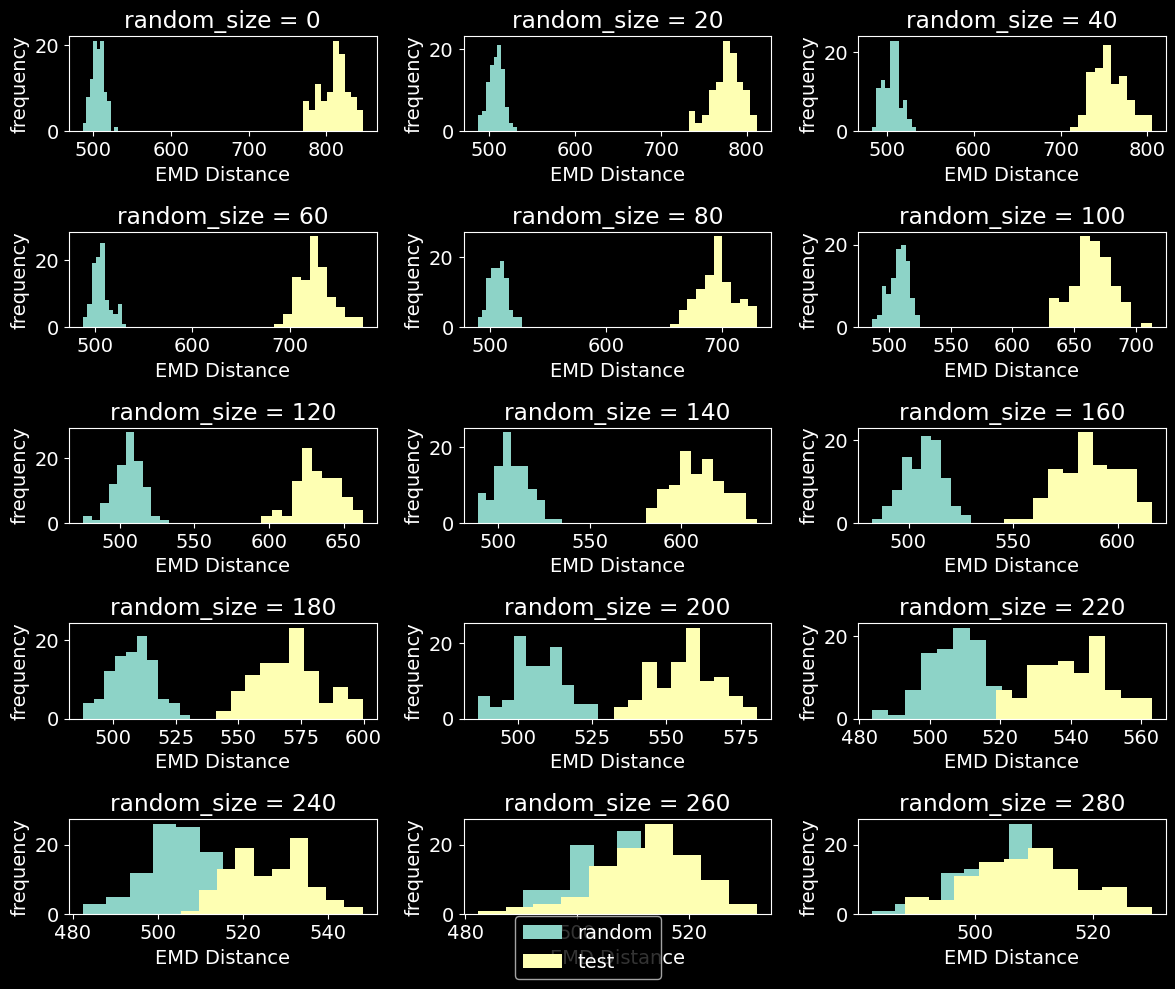

In [97]:
ITERATION_NUMBER = 100
SAMPLE_SIZE = 300

random_sizes = list(range(0,SAMPLE_SIZE,20))
snr_values = np.zeros((len(random_sizes)))
means_array = np.zeros((len(random_sizes), ITERATION_NUMBER, 9))  # 9 is number of question

mean_distance_random = np.zeros((len(random_sizes)))
mean_distance_test = np.zeros((len(random_sizes)))

var_distance_random = np.zeros((len(random_sizes)))
var_distance_test = np.zeros((len(random_sizes)))

with plt.rc_context({
    'axes.edgecolor':'white',
    'xtick.color':'white',
    'ytick.color':'white',
    'figure.facecolor':'white',
    'axes.labelcolor': 'white',
    'grid.color': 'b0b0b0',
    'font.size': '14',
    # 'image.cmap': 'Spectral',
}):
    plt.style.use('dark_background')
    fig, axs = plt.subplots(5,3, figsize=(12,10))

    for index, random_size in enumerate(random_sizes):
        distances_random = []
        distances_test = []

        for i in range(0, ITERATION_NUMBER):
            sample_random = createSamples(SAMPLE_SIZE,radix)
            sample_random2 = createSamples(SAMPLE_SIZE,radix)

            if random_size == 0:
                sample_test = sample_300[:SAMPLE_SIZE]
            else:
                # mixing up with random data
                sample_random3 = createSamples(random_size,radix)
                sample_test = np.concatenate((sample_random3, sample_300[:(SAMPLE_SIZE-random_size)]))

            # store the mean response for each questions
            means_array[index][i] = sample_test.mean(axis=0)

            distance_random = earth_mover_distance(sample_random, sample_random2, radix, question_types)
            distance_test = earth_mover_distance(sample_random, sample_test, radix, question_types)

            distances_random.append(distance_random)
            distances_test.append(distance_test)

        snr = (np.mean(distances_test)-np.mean(distances_random)) / np.std(distances_random)
        print(f"random_size = {random_size}: SNR: {snr}")

        # store the values
        snr_values[index] = snr
        mean_distance_random[index] = np.mean(distances_random)
        mean_distance_test[index] = np.mean(distances_test)
        var_distance_random[index] = np.var(distances_random)
        var_distance_test[index] = np.var(distances_test)

        # plotting
        axs[index//3][index%3].hist(distances_random, label="random")
        axs[index//3][index%3].hist(distances_test,label="test")

        axs[index//3][index%3].set_title(f"random_size = {random_size}")    
        axs[index//3][index%3].set_xlabel("EMD Distance")
        axs[index//3][index%3].set_ylabel("frequency")
        # axs[index//3][index%3].legend()

    handles, labels = axs[0][0].get_legend_handles_labels()

    fig.legend(handles, labels, loc='lower center')
    plt.tight_layout()  # to avoid overlapping titles
    plt.show()

    fig.savefig("emd_dists_300_dark_2.png", transparent=True)

random_size = 0: SNR: 13.690873758651074
random_size = 7: SNR: 9.679967105551448
random_size = 14: SNR: 8.689248406389789
random_size = 21: SNR: 8.835590738531993
random_size = 28: SNR: 6.455739199505399
random_size = 35: SNR: 6.719710771062246
random_size = 42: SNR: 5.094311440628725
random_size = 49: SNR: 4.153809027254904
random_size = 56: SNR: 2.5676688917033834
random_size = 63: SNR: 2.038041618288642
random_size = 70: SNR: 1.2280096942333556
random_size = 77: SNR: 0.2978529346891683
random_size = 84: SNR: 0.26039138782429044
random_size = 91: SNR: 0.1492996230456947
random_size = 98: SNR: 0.04088798981144473


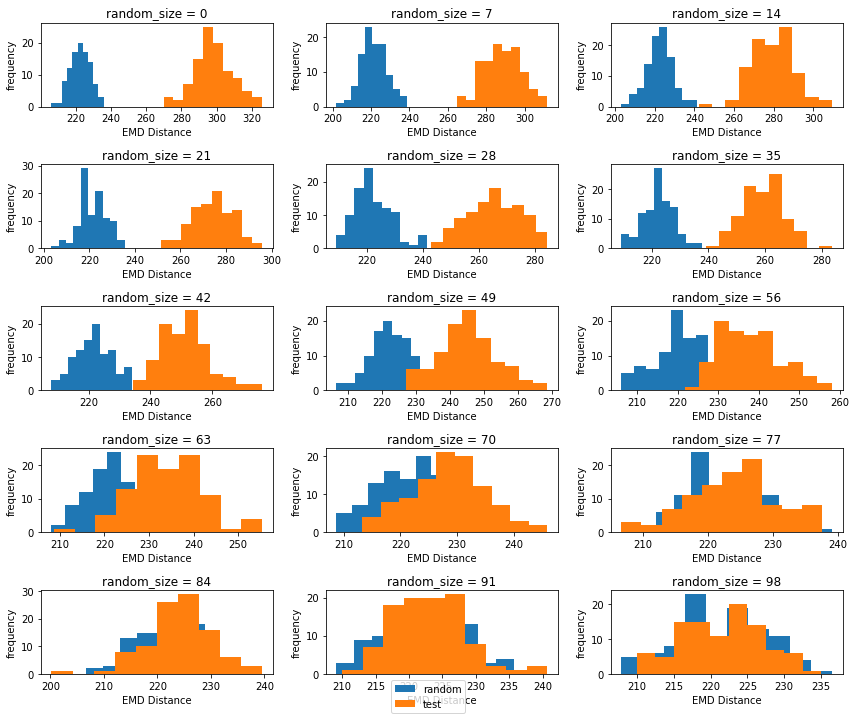

In [191]:
ITERATION_NUMBER = 100
SAMPLE_SIZE = 100

random_sizes = list(range(0,SAMPLE_SIZE,7))
snr_values = np.zeros((len(random_sizes)))
means_array = np.zeros((len(random_sizes), ITERATION_NUMBER, 9))  # 9 is number of question

mean_distance_random = np.zeros((len(random_sizes)))
mean_distance_test = np.zeros((len(random_sizes)))

var_distance_random = np.zeros((len(random_sizes)))
var_distance_test = np.zeros((len(random_sizes)))

fig, axs = plt.subplots(5,3, figsize=(12,10))

for index, random_size in enumerate(random_sizes):
    distances_random = []
    distances_test = []

    for i in range(0, ITERATION_NUMBER):
        sample_random = createSamples(SAMPLE_SIZE,radix)
        sample_random2 = createSamples(SAMPLE_SIZE,radix)
        
        if random_size == 0:
            sample_test = sample_300[:SAMPLE_SIZE]
        else:
            # mixing up with random data
            sample_random3 = createSamples(random_size,radix)
            sample_test = np.concatenate((sample_random3, sample_300[:(SAMPLE_SIZE-random_size)]))
                    
        # store the mean response for each questions
        means_array[index][i] = sample_test.mean(axis=0)

        distance_random = earth_mover_distance(sample_random, sample_random2, radix, question_types)
        distance_test = earth_mover_distance(sample_random, sample_test, radix, question_types)

        distances_random.append(distance_random)
        distances_test.append(distance_test)

    snr = (np.mean(distances_test)-np.mean(distances_random)) / np.std(distances_random)
    print(f"random_size = {random_size}: SNR: {snr}")
    
    # store the values
    snr_values[index] = snr
    mean_distance_random[index] = np.mean(distances_random)
    mean_distance_test[index] = np.mean(distances_test)
    var_distance_random[index] = np.var(distances_random)
    var_distance_test[index] = np.var(distances_test)
    
    # plotting
    axs[index//3][index%3].hist(distances_random, label="random")
    axs[index//3][index%3].hist(distances_test,label="test")

    axs[index//3][index%3].set_title(f"random_size = {random_size}")    
    axs[index//3][index%3].set_xlabel("EMD Distance")
    axs[index//3][index%3].set_ylabel("frequency")
    # axs[index//3][index%3].legend()
    
handles, labels = axs[0][0].get_legend_handles_labels()

fig.legend(handles, labels, loc='lower center')
plt.tight_layout()  # to avoid overlapping titles
plt.show()

# T-statistics?

random_size = 0: t-stat: -139.1710780131256 	p-value (two-sided test): 3.238738401494592e-151
random_size = 20: t-stat: -143.59178170538428 	p-value (two-sided test): 1.2924274499199459e-171
random_size = 40: t-stat: -133.76200773638126 	p-value (two-sided test): 7.155054524292602e-165
random_size = 60: t-stat: -100.41012244829773 	p-value (two-sided test): 3.467158645316052e-126
random_size = 80: t-stat: -117.7858867394986 	p-value (two-sided test): 1.3247550572958032e-155
random_size = 100: t-stat: -91.85933830447512 	p-value (two-sided test): 3.0558914746562198e-130
random_size = 120: t-stat: -74.48826216196632 	p-value (two-sided test): 1.595210798957459e-122
random_size = 140: t-stat: -60.438075866007935 	p-value (two-sided test): 3.1095416671122846e-116
random_size = 160: t-stat: -47.743667096977575 	p-value (two-sided test): 1.0907620101001709e-104
random_size = 180: t-stat: -42.888877815807014 	p-value (two-sided test): 2.194268765986187e-93
random_size = 200: t-stat: -32.34816

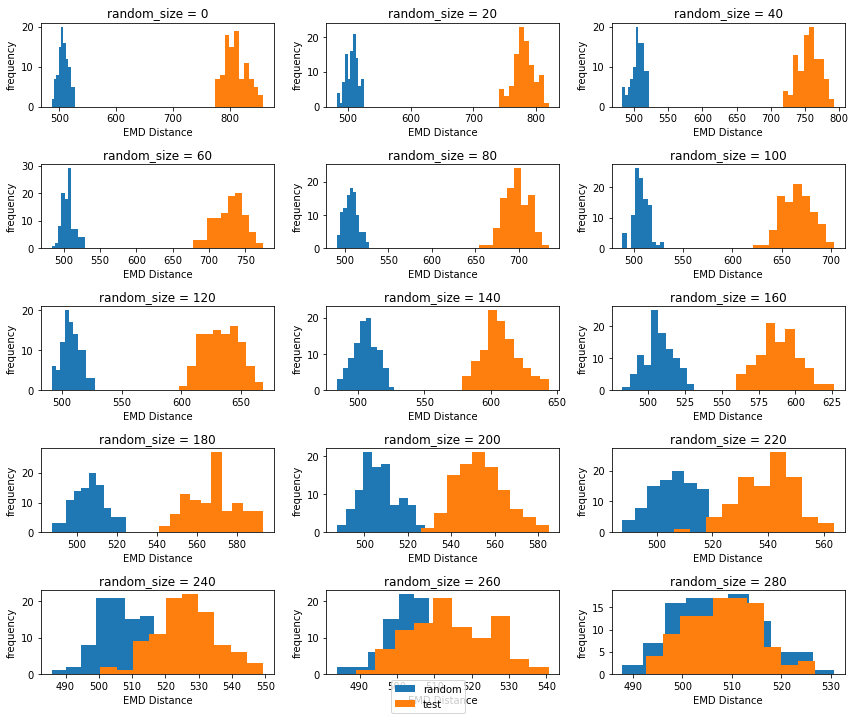

In [177]:
ITERATION_NUMBER = 100
SAMPLE_SIZE = 300

random_sizes = list(range(0,SAMPLE_SIZE,20))
p_values = np.zeros((len(random_sizes)))
means_array = np.zeros((len(random_sizes), ITERATION_NUMBER, 9))  # 9 is number of question

mean_distance_random = np.zeros((len(random_sizes)))
mean_distance_test = np.zeros((len(random_sizes)))

var_distance_random = np.zeros((len(random_sizes)))
var_distance_test = np.zeros((len(random_sizes)))

fig, axs = plt.subplots(5,3, figsize=(12,10))

for index, random_size in enumerate(random_sizes):
    distances_random = []
    distances_test = []

    for i in range(0, ITERATION_NUMBER):
        sample_random = createSamples(SAMPLE_SIZE,radix)
        sample_random2 = createSamples(SAMPLE_SIZE,radix)
        
        if random_size == 0:
            sample_test = sample_300[:SAMPLE_SIZE]
        else:
            # mixing up with random data
            sample_random3 = createSamples(random_size,radix)
            sample_test = np.concatenate((sample_random3, sample_300[:(SAMPLE_SIZE-random_size)]))
                    
        # store the mean response for each questions
        means_array[index][i] = sample_test.mean(axis=0)

        distance_random = earth_mover_distance(sample_random, sample_random2, radix, question_types)
        distance_test = earth_mover_distance(sample_random, sample_test, radix, question_types)

        distances_random.append(distance_random)
        distances_test.append(distance_test)

    res = scipy.stats.ttest_ind(distances_random, distances_test, equal_var=False)
    print(f"random_size = {random_size}: t-stat: {res[0]} \tp-value (two-sided test): {res[1]}")
    
    # store the values
    p_values[index] = res[1]
    mean_distance_random[index] = np.mean(distances_random)
    mean_distance_test[index] = np.mean(distances_test)
    var_distance_random[index] = np.var(distances_random)
    var_distance_test[index] = np.var(distances_test)
    
    # plotting
    axs[index//3][index%3].hist(distances_random, label="random")
    axs[index//3][index%3].hist(distances_test,label="test")

    axs[index//3][index%3].set_title(f"random_size = {random_size}")    
    axs[index//3][index%3].set_xlabel("EMD Distance")
    axs[index//3][index%3].set_ylabel("frequency")
    # axs[index//3][index%3].legend()
    
handles, labels = axs[0][0].get_legend_handles_labels()

fig.legend(handles, labels, loc='lower center')
plt.tight_layout()  # to avoid overlapping titles
plt.show()

random_size = 0: t-stat: -64.29483001882292 	p-value (two-sided test): 7.680148801353303e-115
random_size = 8: t-stat: -52.05647799777845 	p-value (two-sided test): 1.8522332742011836e-98
random_size = 16: t-stat: -46.10265532424623 	p-value (two-sided test): 2.9194404903813914e-92
random_size = 24: t-stat: -42.81838060601721 	p-value (two-sided test): 3.3855951962066224e-90
random_size = 32: t-stat: -38.74218051651702 	p-value (two-sided test): 4.561289254706041e-87
random_size = 40: t-stat: -28.609103194957676 	p-value (two-sided test): 1.5180235304131419e-64
random_size = 48: t-stat: -20.610205566295324 	p-value (two-sided test): 1.765186200976218e-49
random_size = 56: t-stat: -18.508950364260997 	p-value (two-sided test): 2.034862719484831e-44
random_size = 64: t-stat: -11.6108885100136 	p-value (two-sided test): 7.121798031754913e-24
random_size = 72: t-stat: -6.462952796448052 	p-value (two-sided test): 8.717857634612616e-10
random_size = 80: t-stat: -3.3001760687759436 	p-value 

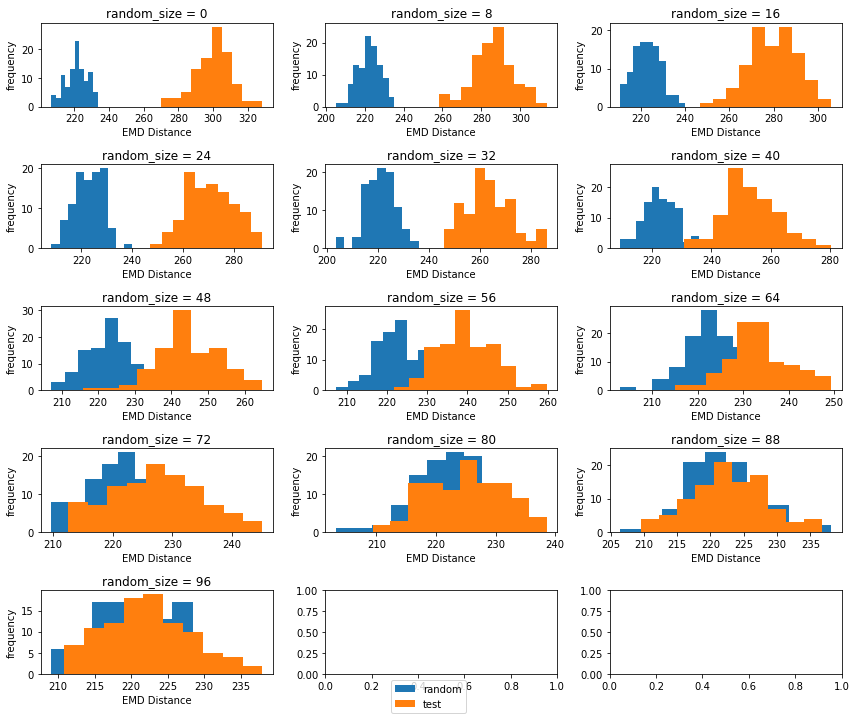

In [180]:
ITERATION_NUMBER = 100
SAMPLE_SIZE = 100

random_sizes = list(range(0,SAMPLE_SIZE,8))
p_values = np.zeros((len(random_sizes)))
means_array = np.zeros((len(random_sizes), ITERATION_NUMBER, 9))  # 9 is number of question

mean_distance_random = np.zeros((len(random_sizes)))
mean_distance_test = np.zeros((len(random_sizes)))

var_distance_random = np.zeros((len(random_sizes)))
var_distance_test = np.zeros((len(random_sizes)))

fig, axs = plt.subplots(5,3, figsize=(12,10))

for index, random_size in enumerate(random_sizes):
    distances_random = []
    distances_test = []

    for i in range(0, ITERATION_NUMBER):
        sample_random = createSamples(SAMPLE_SIZE,radix)
        sample_random2 = createSamples(SAMPLE_SIZE,radix)
        
        if random_size == 0:
            sample_test = sample_300[:SAMPLE_SIZE]
        else:
            # mixing up with random data
            sample_random3 = createSamples(random_size,radix)
            sample_test = np.concatenate((sample_random3, sample_300[:(SAMPLE_SIZE-random_size)]))
                    
        # store the mean response for each questions
        means_array[index][i] = sample_test.mean(axis=0)

        distance_random = earth_mover_distance(sample_random, sample_random2, radix, question_types)
        distance_test = earth_mover_distance(sample_random, sample_test, radix, question_types)

        distances_random.append(distance_random)
        distances_test.append(distance_test)

    res = scipy.stats.ttest_ind(distances_random, distances_test, equal_var=False)
    print(f"random_size = {random_size}: t-stat: {res[0]} \tp-value (two-sided test): {res[1]}")
    
    # store the values
    p_values[index] = res[1]
    mean_distance_random[index] = np.mean(distances_random)
    mean_distance_test[index] = np.mean(distances_test)
    var_distance_random[index] = np.var(distances_random)
    var_distance_test[index] = np.var(distances_test)
    
    # plotting
    axs[index//3][index%3].hist(distances_random, label="random")
    axs[index//3][index%3].hist(distances_test,label="test")

    axs[index//3][index%3].set_title(f"random_size = {random_size}")    
    axs[index//3][index%3].set_xlabel("EMD Distance")
    axs[index//3][index%3].set_ylabel("frequency")
    # axs[index//3][index%3].legend()
    
handles, labels = axs[0][0].get_legend_handles_labels()

fig.legend(handles, labels, loc='lower center')
plt.tight_layout()  # to avoid overlapping titles
plt.show()

# SNR

In [103]:
ITERATION_NUMBER = 100

sizes = list(range(50,301,50))
snr_values = np.zeros((len(sizes), 10))
t_values = np.zeros((len(sizes), 10))

# NOTE: THEY ARE NOW ACTUALLY MODE NOT MEAN
answer_mean_values = np.zeros((len(sizes), 10, 9))


for index2, SAMPLE_SIZE in enumerate(sizes):
    print(f"\nSAMPLE_SIZE={SAMPLE_SIZE}")
    random_sizes = list(range(0,SAMPLE_SIZE,SAMPLE_SIZE//10))

    mean_distance_random = np.zeros((len(random_sizes)))
    mean_distance_test = np.zeros((len(random_sizes)))

    var_distance_random = np.zeros((len(random_sizes)))
    var_distance_test = np.zeros((len(random_sizes)))

    for index, random_size in enumerate(random_sizes):
        distances_random = []
        distances_test = []

        means = np.zeros((ITERATION_NUMBER, 9))
        
        for i in range(0, ITERATION_NUMBER):
            sample_random = createSamples(SAMPLE_SIZE,radix)
            sample_random2 = createSamples(SAMPLE_SIZE,radix)

            if random_size == 0:
                sample_test = sample_300[:SAMPLE_SIZE]
            else:
                # mixing up with random data
                sample_random3 = createSamples(random_size,radix)
                sample_test = np.concatenate((sample_random3, sample_300[:(SAMPLE_SIZE-random_size)]))

            distance_random = earth_mover_distance(sample_random, sample_random2, radix, question_types)
            distance_test = earth_mover_distance(sample_random, sample_test, radix, question_types)

            # means[i] = np.mean(sample_test, axis=0)
            means[i] = scipy.stats.mode(sample_test, axis=0)[0]
            
            distances_random.append(distance_random)
            distances_test.append(distance_test)

        res = scipy.stats.ttest_ind(distances_random, distances_test, equal_var=False)
        snr = (np.mean(distances_test)-np.mean(distances_random)) / np.std(distances_random)
        print(f"random_size = {random_size}: SNR: {snr} \tt-stat: {res[0]} \tp-value (two-sided test): {res[1]}")

        # store the values
        snr_values[index2][index] = snr
        t_values[index2][index] = res[0]
        answer_mean_values[index2][index] = np.mean(means, axis=0)


SAMPLE_SIZE=50
random_size = 0: SNR: 7.3086360904870356 	t-stat: -37.904541319160224 	p-value (two-sided test): 5.3452589796821395e-83
random_size = 5: SNR: 5.390949613748653 	t-stat: -29.550103157579084 	p-value (two-sided test): 3.388102799304834e-69
random_size = 10: SNR: 4.036729338763111 	t-stat: -22.488066224262404 	p-value (two-sided test): 2.427947308016701e-53
random_size = 15: SNR: 2.9668426745101946 	t-stat: -15.647152950314135 	p-value (two-sided test): 1.6922233800632286e-34
random_size = 20: SNR: 2.2901225933931895 	t-stat: -13.454706269275915 	p-value (two-sided test): 4.550592097279267e-29
random_size = 25: SNR: 1.0427625913484115 	t-stat: -6.331530680972617 	p-value (two-sided test): 1.775734776829812e-09
random_size = 30: SNR: 0.9543426735465605 	t-stat: -5.844277218309856 	p-value (two-sided test): 2.224171627634473e-08
random_size = 35: SNR: 0.5001588439679875 	t-stat: -3.405519133691206 	p-value (two-sided test): 0.0008001235433077845
random_size = 40: SNR: 0.1793

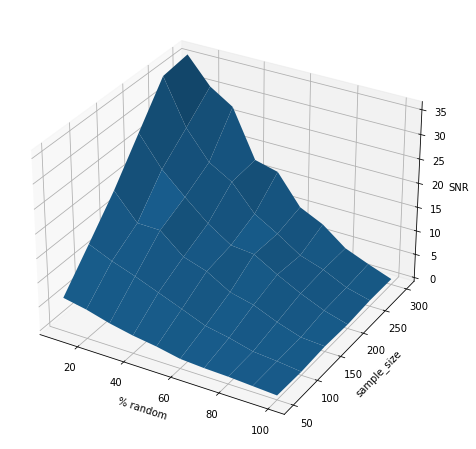

In [43]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')

x,y = np.meshgrid(list(range(10,101,10)), np.array(sizes))
ax.plot_surface(x, y, snr_values)
ax.set_ylabel("sample_size")
ax.set_xlabel("% random")
ax.set_zlabel("SNR")

plt.show()

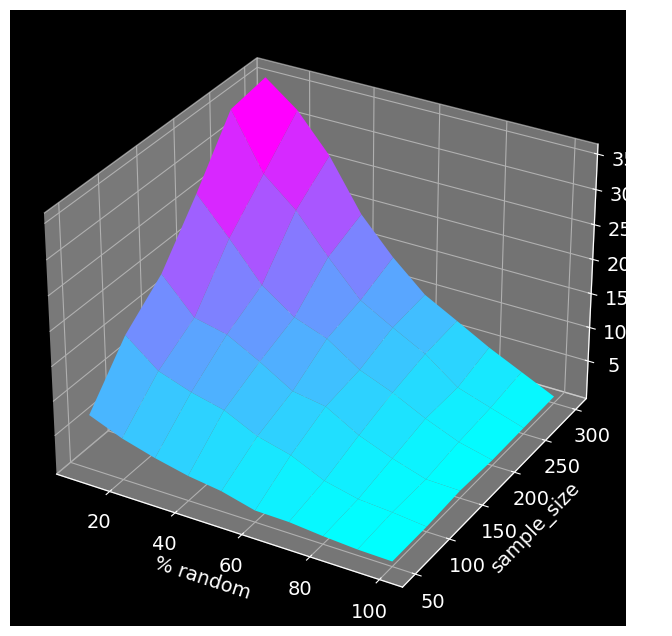

In [105]:
plt.style.use('dark_background')

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

with plt.rc_context({
    'axes.edgecolor':'white',
    'xtick.color':'white',
    'ytick.color':'white',
    'figure.facecolor':'white',
    'axes.labelcolor': 'white',
    'grid.color': 'b0b0b0',
    'image.cmap': 'Spectral',
    'font.size': '14',
}):
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111, projection='3d')

    x,y = np.meshgrid(list(range(10,101,10)), np.array(sizes))
    ax.plot_surface(x, y, snr_values, cmap=cm.cool)
    ax.set_ylabel("sample_size")
    ax.set_xlabel("% random")
    ax.set_zlabel("Signal-to-Noise Ratio")

    plt.show()
fig.savefig("snr_dark.png", transparent=True)

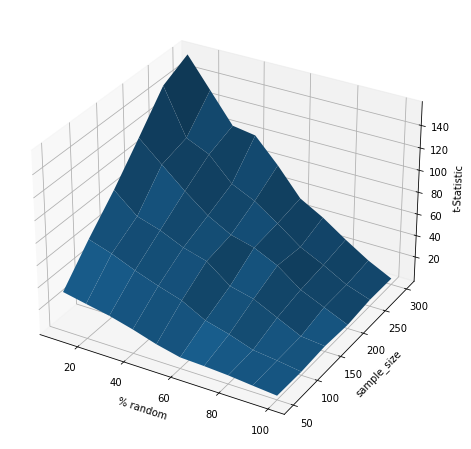

In [39]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')

x,y = np.meshgrid(list(range(10,101,10)), np.array(sizes))
ax.plot_surface(x, y, np.abs(t_values))
ax.set_ylabel("sample_size")
ax.set_xlabel("% random")
ax.set_zlabel("t-Statistic")

plt.show()

# Do mode change when we mix in random data / increase sample size?

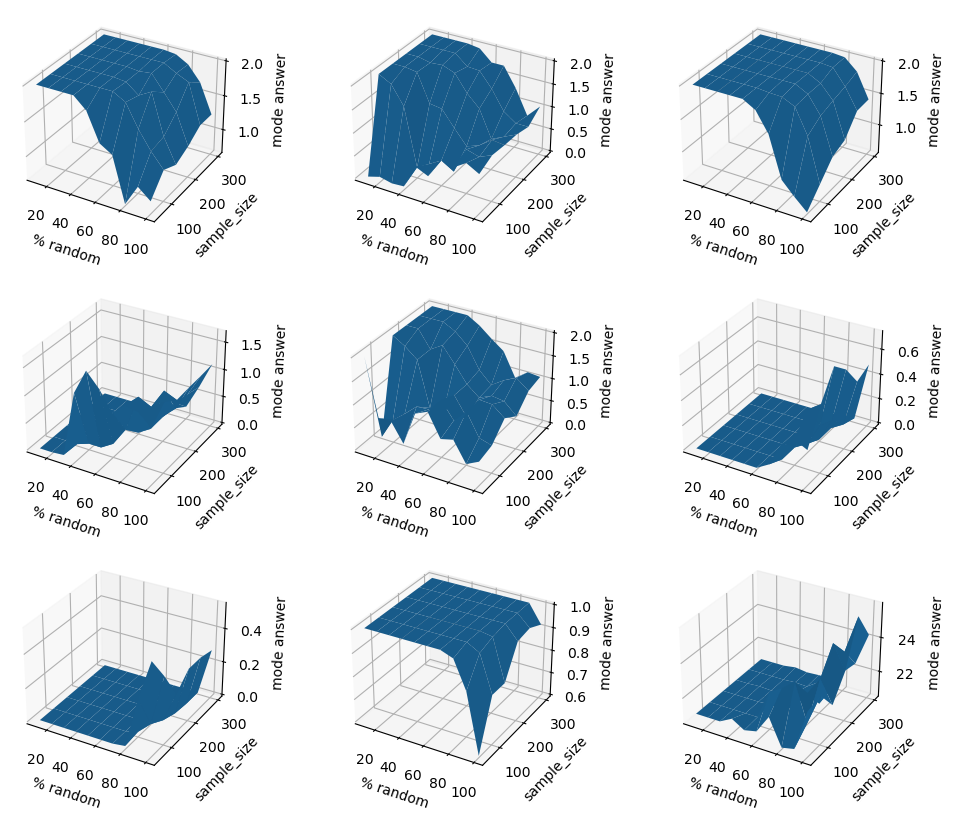

In [71]:
plt.style.use('default')
from mpl_toolkits.mplot3d import Axes3D

fig, axs = plt.subplots(3,3, figsize=(12,10), subplot_kw={"projection": '3d'})

for i in range(0,9):
    x,y = np.meshgrid(list(range(10,101,10)), np.array(sizes))
    
    ax = axs[i//3][i%3]
    
    ax.plot_surface(x, y, answer_mean_values[:,:,i])
    ax.set_ylabel("sample_size")
    ax.set_xlabel("% random")
    ax.set_zlabel("mode answer")
    
    # if i != 8:
    #     ax.set_zlim(0,2)
    # ax.set_zlim(0,radix[i])

plt.show()
fig.savefig("answers.png", transparent=True)

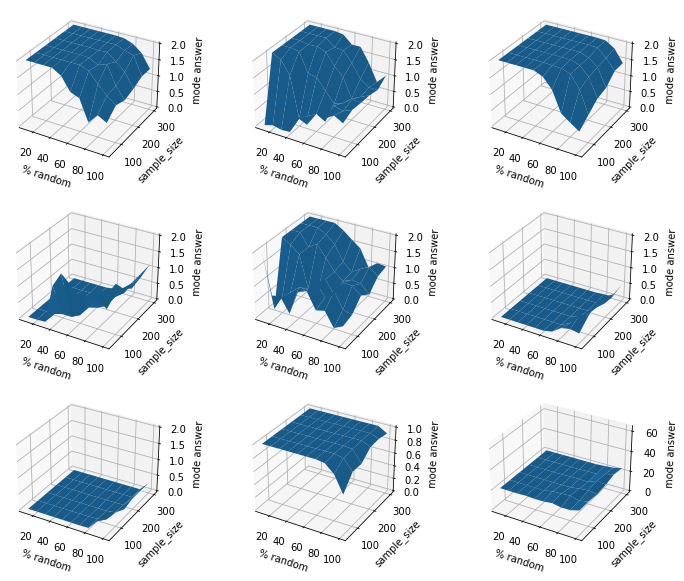

In [42]:
from mpl_toolkits.mplot3d import Axes3D

fig, axs = plt.subplots(3,3, figsize=(12,10), subplot_kw={"projection": '3d'})

for i in range(0,9):
    x,y = np.meshgrid(list(range(10,101,10)), np.array(sizes))
    
    ax = axs[i//3][i%3]
    
    ax.plot_surface(x, y, answer_mean_values[:,:,i])
    ax.set_ylabel("sample_size")
    ax.set_xlabel("% random")
    ax.set_zlabel("mode answer")
    
    # if i != 8:
    #     ax.set_zlim(0,2)
    ax.set_zlim(0,radix[i]-1)

plt.show()

# END